### Augment tasmin from NEX-GDDP-CMIP6 for existing orchards using xclim.

# References:
- https://www.almanac.com/gardening/frostdates#:~:text=Frost%20is%20predicted%20when%20air,exposes%20surfaces%20to%20radiative%20cooling.


In [1]:
import xclim
import sys 
import os
import s3fs

rel_path = "../src"
directory_path = os.path.abspath(os.path.join(os.getcwd(), rel_path))
sys.path.append(directory_path)

from nex_gddp_cmip6 import get_nex_dataset, TIME_OPTIMIZED_SCENARIOS, AVAILABLE_VARIABLES, load_region, select_region

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import dask
from dask.distributed import Client

# https://dask.pydata.org/en/latest/diagnostics-local.html
from dask.distributed import Client, progress
from dask.diagnostics import ProgressBar

In [2]:
# Initiate Dask Cluster

endpoint = ""

if endpoint:
    client = Client(endpoint)

else:
    client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51120,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.93 GiB
Comm: tcp://127.0.0.1:51140,Total threads: 3
Dashboard: http://127.0.0.1:51145/status,Memory: 3.98 GiB
Nanny: tcp://127.0.0.1:51123,


In [4]:
# when ready to shutdown cluster
# client.shutdown()

In [5]:
# Load Data

ds_historical = get_nex_dataset(AVAILABLE_VARIABLES,["historical"])

geodf = load_region('../assets/data/external/MI_avas.geojson')
ds_historical_clipped = select_region(ds_historical, geodf)

In [14]:
ds_historical

<xarray.Dataset> Size: 15TB
Dimensions:   (model: 20, scenario: 1, time: 23741, lat: 600, lon: 1440)
Coordinates:
  * lat       (lat) float64 5kB -59.88 -59.62 -59.38 ... 89.38 89.62 89.88
  * lon       (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * model     (model) <U10 800B 'ACCESS-CM2' 'ACCESS-ESM' ... 'UKESM1-0-L'
  * scenario  (scenario) <U10 40B 'historical'
  * time      (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31T...
Data variables:
    hurs      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    huss      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    pr        (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    rlds      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    rsds      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    sfcWind   (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tas       (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tasmax    (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tasmin    (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
Attributes: (12/23)
    Conventions:           CF-1.7
    activity:              NEX-GDDP-CMIP6
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY 4.0
    cmip6_source_id:       ACCESS-CM2
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    source:                BCSD
    title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
    tracking_id:           f9f489de-f5f7-43de-8f55-f0c001fad19a
    variant_label:         r1i1p1f1
    version:               1.1
    crs:                   EPSG:4326

In context, 0c is frost date for Michigan. 

- https://www.almanac.com/gardening/frostdates/MI/Detroit#:~:text=Frost%20is%20predicted%20when%20air,exposes%20surfaces%20to%20radiative%20cooling.
- https://www.canr.msu.edu/resources/frost-free-dates

In [6]:
# using one climate model, between a very short time range of 10 years
da = ds_historical_clipped['tasmin'].sel(model = 'ACCESS-CM2', time=slice('1950-01-01T12:00:00.000000000', '1960-12-31T12:00:00.000000000'))

In [17]:
da

<xarray.DataArray 'tasmin' (scenario: 1, time: 4018, lat: 16, lon: 14)> Size: 4MB
dask.array<getitem, shape=(1, 4018, 16, 14), dtype=float32, chunksize=(1, 4018, 13, 12), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 128B 41.88 42.12 42.38 ... 45.12 45.38 45.62
  * lon          (lon) float64 112B 93.38 93.62 93.88 ... 96.12 96.38 96.62
    model        <U10 40B 'ACCESS-CM2'
  * scenario     (scenario) <U10 40B 'historical'
  * time         (time) datetime64[ns] 32kB 1950-01-01T12:00:00 ... 1960-12-3...
    spatial_ref  int32 4B 0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: minimum
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Minimum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

frost free season start (default parameters)

Notes:
1. since a data array is passed, dask is running the hood.
2. degree Celcius converted into Kelvin scale is 273.15 K
2. frost_free_season_start returns 'Day of the year of the beginning of the frost-free season, defined as the {window}th consecutive day when minimum daily temperature exceeds {thresh}'

In [43]:
# https://docs.dask.org/en/stable/diagnostics-distributed.html
# https://xclim.readthedocs.io/en/stable/_modules/xclim/core/units.html

# takes about 10-15 minutes
ffss_da = xclim.indicators.atmos.frost_free_season_start(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [18]:
ds_historical

<xarray.Dataset> Size: 15TB
Dimensions:   (model: 20, scenario: 1, time: 23741, lat: 600, lon: 1440)
Coordinates:
  * lat       (lat) float64 5kB -59.88 -59.62 -59.38 ... 89.38 89.62 89.88
  * lon       (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * model     (model) <U10 800B 'ACCESS-CM2' 'ACCESS-ESM' ... 'UKESM1-0-L'
  * scenario  (scenario) <U10 40B 'historical'
  * time      (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31T...
Data variables:
    hurs      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    huss      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    pr        (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    rlds      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    rsds      (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    sfcWind   (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tas       (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tasmax    (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
    tasmin    (model, scenario, time, lat, lon) float32 2TB dask.array<chunksize=(20, 1, 23741, 15, 15), meta=np.ndarray>
Attributes: (12/23)
    Conventions:           CF-1.7
    activity:              NEX-GDDP-CMIP6
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY 4.0
    cmip6_source_id:       ACCESS-CM2
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    source:                BCSD
    title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
    tracking_id:           f9f489de-f5f7-43de-8f55-f0c001fad19a
    variant_label:         r1i1p1f1
    version:               1.1
    crs:                   EPSG:4326

In [65]:
# 20 - 25 minutes
ffse_da = xclim.indicators.atmos.frost_free_season_end(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [67]:
# fast 1-2 seconds
ffsl_da = xclim.indicators.atmos.frost_free_season_length(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [68]:
# < 1 second
frost_days_da = xclim.indicators.atmos.frost_days(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [71]:
last_spring_frost_da = xclim.indicators.atmos.last_spring_frost(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 
late_frost_days_da = xclim.indicators.atmos.late_frost_days(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [72]:
consecutive_frost_days_da = xclim.indicators.atmos.consecutive_frost_days(tasmin = da, ds = ds_historical_clipped, thresh = '273.15 degK') 

In [44]:
# converted_da = xclim.core.units.convert_units_to(da,'degF')
# filled_converted_da = converted_da.fillna(0)
# filled_converted_da

<xarray.DataArray 'tasmin' (scenario: 1, time: 4018, lat: 16, lon: 14)> Size: 4MB
dask.array<where, shape=(1, 4018, 16, 14), dtype=float32, chunksize=(1, 4018, 13, 12), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 128B 41.88 42.12 42.38 ... 45.12 45.38 45.62
  * lon          (lon) float64 112B 93.38 93.62 93.88 ... 96.12 96.38 96.62
    model        <U10 40B 'ACCESS-CM2'
  * scenario     (scenario) <U10 40B 'historical'
  * time         (time) datetime64[ns] 32kB 1950-01-01T12:00:00 ... 1960-12-3...
    spatial_ref  int32 4B 0
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: minimum
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    long_name:      Daily Minimum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          °F

In [6]:
filled_converted_da.isnull().any().values

array(False)

In [17]:
da.isnull().any()

<xarray.DataArray 'tasmin' ()> Size: 1B
dask.array<any-aggregate, shape=(), dtype=bool, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    model        <U10 40B 'ACCESS-CM2'
    spatial_ref  int32 4B 0

In [45]:
# window:  The length of the averaging window, in years.
 
# usda_hardiness_zones_da = xclim.indices.hardiness_zones(tasmin = filled_converted_da, window = 5,freq='YE')
### the nans are ok here, since we don't want them anyways, and the temperature unit is converted within function. Freqency is Year End, which is equivalent to Annual 
usda_hardiness_zones_da = xclim.indices.hardiness_zones(tasmin = da, window = 5,freq='YE')
# usda_hardiness_zones_da = xclim.indicators.atmos.usda_hardiness_zones(tasmin = da, window = 5, freq=['A'])

Though using the indicator instead of indices is preferred, the frequency selection check is wrong

In [13]:
usda_hardiness_zones_da

<xarray.DataArray 'tasmin' (scenario: 1, time: 11, lat: 16, lon: 14)> Size: 20kB
dask.array<where, shape=(1, 11, 16, 14), dtype=float64, chunksize=(1, 5, 13, 12), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 128B 41.88 42.12 42.38 ... 45.12 45.38 45.62
  * lon          (lon) float64 112B 93.38 93.62 93.88 ... 96.12 96.38 96.62
    model        <U10 40B 'ACCESS-CM2'
  * scenario     (scenario) <U10 40B 'historical'
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 88B 1950-12-31 1951-12-31 ... 1960-12-31
Attributes:
    units:

Possibly due to the low level nature of this function, the rolling mean does not come into effect until the window is full.

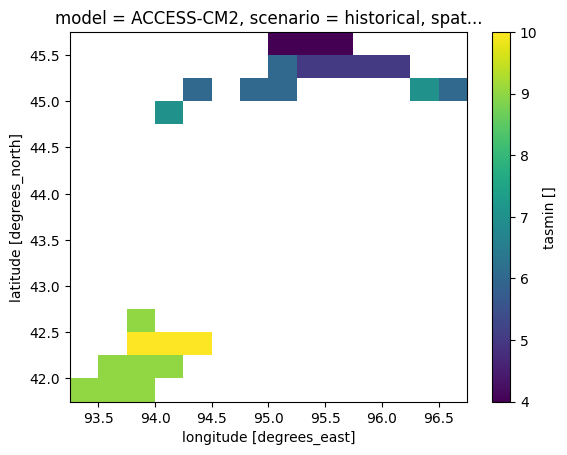

In [46]:
usda_hardiness_zones_da.isel(time=6).plot()

In [53]:
ffss_da 

<xarray.DataArray 'frost_free_season_start' (scenario: 1, time: 11, lat: 16,
                                             lon: 14)> Size: 20kB
dask.array<where, shape=(1, 11, 16, 14), dtype=float64, chunksize=(1, 1, 13, 12), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 112B 93.38 93.62 93.88 ... 96.12 96.38 96.62
    model        <U10 40B 'ACCESS-CM2'
    spatial_ref  int32 4B 0
  * scenario     (scenario) <U10 40B 'historical'
  * lat          (lat) float64 128B 41.88 42.12 42.38 ... 45.12 45.38 45.62
  * time         (time) datetime64[ns] 88B 1950-01-01 1951-01-01 ... 1960-01-01
Attributes:
    units:          
    is_dayofyear:   1
    calendar:       default
    cell_methods:   area: mean time: minimum
    history:        [2024-03-14 18:34:09] frost_free_season_start: FROST_FREE...
    standard_name:  day_of_year
    long_name:      First day following a period of 5 days with minimum daily...
    description:    Day of the year of the beginning of the frost-free season...

In [78]:
# 1 scenario, 1 time step,
# takes about 2 minutes

#pbar = ProgressBar()
#pbar.register()

operation = ffss_da[0,0].data
ffse_da_t_0 = ffse_da[0,0].data

In [80]:
#frost_free_season_end = ffse_da_t_0.compute()

In [47]:
out = operation.compute()

In [54]:
ffss_da[0,0].data

dask.array<getitem, shape=(16, 14), dtype=float64, chunksize=(13, 12), chunktype=numpy.ndarray>

In [56]:
out.shape

(16, 14)

In [61]:
ffss_da_year_0 = ffss_da.isel(time = 0)

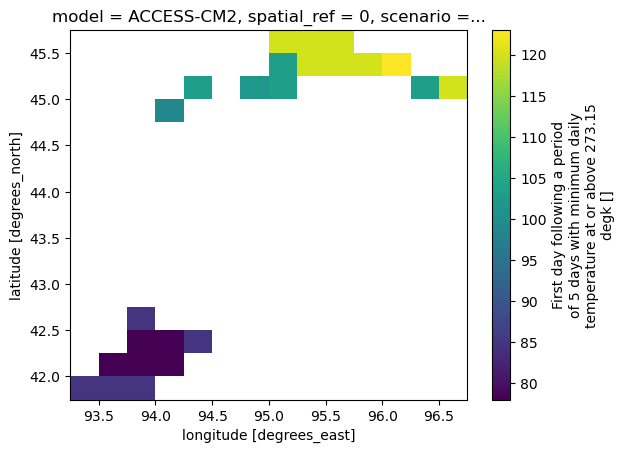

In [63]:
# takes about 2 minutes

# for 1950
ffss_da_year_0.plot()

In [64]:
#ffss_df = ffss_da.to_dask_dataframe(['scenario','time','lat','lon'])

In [28]:
filled_da=da.fillna(0)

In [ ]:
ffss_df

## Testing theories with Toy Data

In [22]:
ds = xr.tutorial.load_dataset("air_temperature")

In [48]:
fake_hz=xclim.indices.hardiness_zones(tasmin = ds.air, window = 5,freq='MS')
# Since there are only 2 years of data, frequency is changed to Monthly

In [36]:
fake_hz

<xarray.DataArray 'air' (time: 24, lat: 25, lon: 53)> Size: 254kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[13., 12., 12., ...,  8.,  8.,  8.],
        [14., 14., 14., ...,  7.,  7.,  8.],
        [15., 14., 14., ...,  7.,  8., 10.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[10., 10., 10., ...,  6.,  6.,  6.],
        [12., 12., 12., ...,  5.,  5.,  6.],
        [13., 12., 11., ...,  5.,  6.,  8.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 192B 2013-01-01 2013-02-01 ... 2014-12-01
Attributes:
    units:

It does display a lot of nans still, but once the time window is full, the data is there.

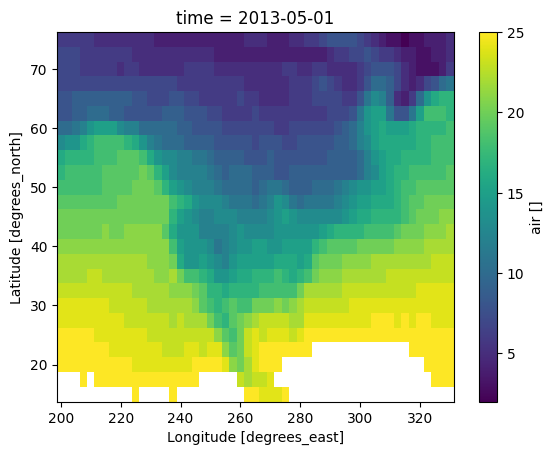

In [43]:
fake_hz.isel(time=4).plot()

In [7]:
faker_hz = xclim.indicators.atmos.usda_hardiness_zones(tasmin = daily_fake, window = 5, freq=['A'])

ValueError: Invalid frequency: ['A']

Even with toy data, the hardiness indicator is not working.